In [1]:
import pandas as pd
import numpy as np
import time 


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import ShuffleSplit

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['global_category','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['global_category','interaction_type','command'])

In [4]:
x_train, y_train = train.drop(columns=['device']), train['device']
x_test, y_test = test.drop(columns=['device']), test['device']

# ADABOOST CLASSIFIER

# Sin hiperparámetros:

In [5]:
ADB = AdaBoostClassifier()

start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [6]:
print(f"AdaBoost training time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

AdaBoost training time: 47.34906244277954s
Train accuracy :  0.325
Test accuracy :  0.391


## Matriz de confusión:

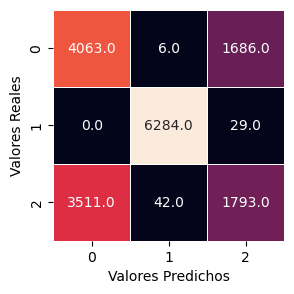

In [9]:
#Guardamos la predicción de Adaboost
y_pred_ADB = ADB.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_ADB)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

# Eligiendo parámetros con RandoSearchCV:

In [7]:
#Número maximo de estimadores
n_estimators = [int(x) for x in np.linspace(start=1, stop=300, num=30)]
#Algoritmo de boosting
algorithm = ['SAMME', 'SAMME.R']
#Tasa de aprendizaje (0 - inf)
learning_rate = [int(x) for x in np.linspace(start=0, stop=100, num=100)]

In [8]:
param_grid = {'n_estimators': n_estimators, 
              'algorithm': algorithm}

ADB_RandoGrid = RandomizedSearchCV(estimator = ADB, param_distributions = param_grid, 
                                   cv = 5, verbose=2, n_jobs = 4)

In [9]:
start = time.time()
ADB_RandoGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
print(f"RandomizedSearch time: {stop - start}s")
print(f'Train accuracy : {ADB_RandoGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB_RandoGrid.score(x_test, y_test): .3f}')

RandomizedSearch time: 2029.5428669452667s
Train accuracy :  0.454
Test accuracy :  0.459


In [17]:
ADB_RandoGrid.best_params_

{'n_estimators': 79, 'learning_rate': 1, 'algorithm': 'SAMME'}

In [11]:
#Probamos los mejores parámetros
ADB = AdaBoostClassifier(n_estimators = 100, algorithm='SAMME')


start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [12]:
print(f"AdaBoost training time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

AdaBoost training time: 77.68266463279724s
Train accuracy :  0.369
Test accuracy :  0.423


## Matriz de confusión:

In [20]:
#Guardamos la predicción de Adaboost
y_pred_ADB = ADB.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_ADB)

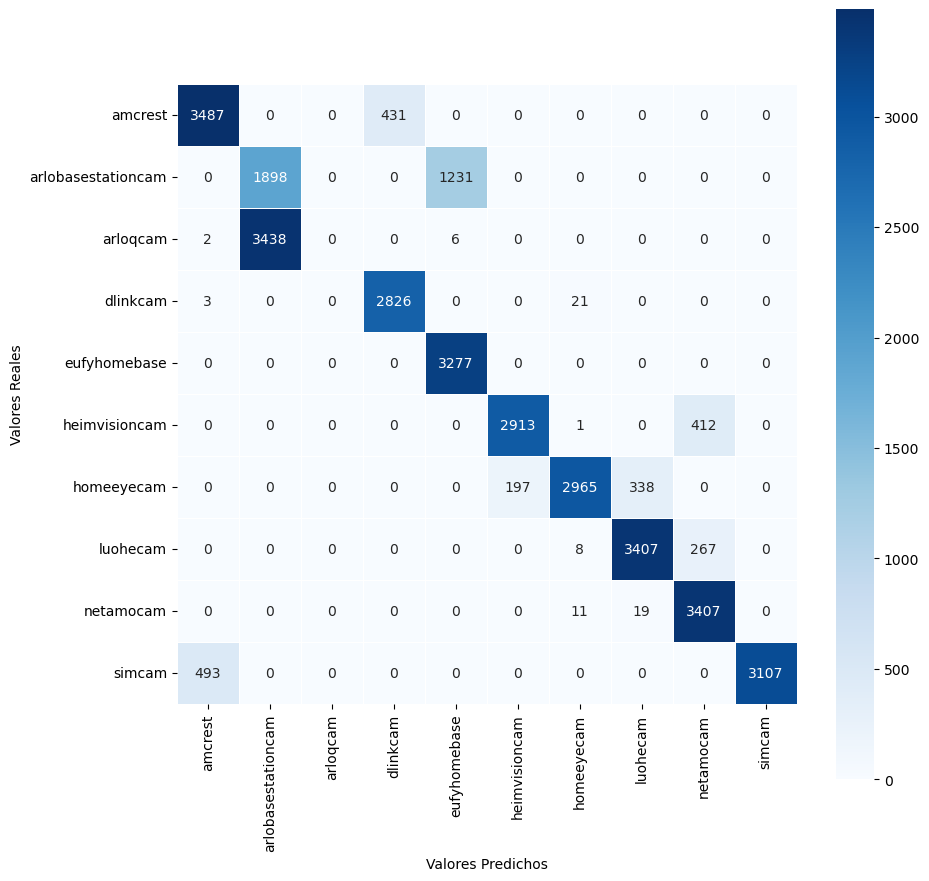

In [21]:
class_names = ['amcrest','arlobasestationcam', 'arloqcam', 'dlinkcam', 'eufyhomebase',
              'heimvisioncam', 'homeeyecam', 'luohecam', 'netamocam', 'simcam']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues')

fig = plt.gcf()
fig.set_size_inches(10, 10)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [17]:
print(metrics.classification_report(y_test, y_pred_ADB))

                 precision    recall  f1-score   support

          AUDIO       0.59      0.98      0.74      3262
         CAMERA       0.99      0.99      0.99      3401
HOME AUTOMATION       0.93      0.28      0.42      3056

       accuracy                           0.76      9719
      macro avg       0.84      0.75      0.72      9719
   weighted avg       0.84      0.76      0.73      9719



## Introduciendo parámetros manualmente:

In [132]:
ADB = AdaBoostClassifier(n_estimators = 20,
                         algorithm='SAMME')


start = time.time()
ADB.fit(x_train, y_train)
stop = time.time()

In [133]:
print(f"AdaBoost training time: {stop - start}s")
print(f'Train accuracy : {ADB.score(x_train, y_train): .3f}')
print(f'Test accuracy : {ADB.score(x_test, y_test): .3f}')

AdaBoost training time: 15.414151191711426s
Train accuracy :  0.349
Test accuracy :  0.402


## Matriz de confusión:

In [141]:
#Guardamos la predicción de Adaboost
y_pred_ADB2 = ADB.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_ADB2)

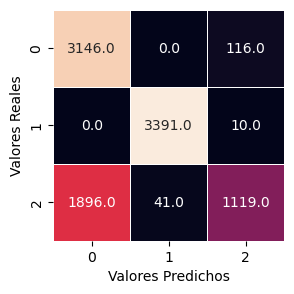

In [142]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [143]:
print(metrics.classification_report(y_test, y_pred_ADB))

                 precision    recall  f1-score   support

          AUDIO       0.59      0.98      0.74      3262
         CAMERA       0.99      0.99      0.99      3401
HOME AUTOMATION       0.93      0.28      0.42      3056

       accuracy                           0.76      9719
      macro avg       0.84      0.75      0.72      9719
   weighted avg       0.84      0.76      0.73      9719



# LGBM:

## Sin hiperparámetros:

In [163]:
LGBM = LGBMClassifier()

In [164]:
start = time.time()
LGBM.fit(x_train, y_train)
stop = time.time()

In [165]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM.score(x_test, y_test): .3f}')

LGBM time: 10.317348957061768s
Train accuracy :  0.112
Test accuracy :  0.131


## Introduciendo hiperparámetros:

In [7]:
boosting_type = ['gbdt', 'dart', 'rf']
#Máx. número de hojas para los 'base learners'
num_leaves = [int(x) for x in np.linspace(start=1, stop=50, num=50)]
#Número de 'boosted trees'
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=20)]
#Mínimo número de datos que se necesitan en las hojas

In [8]:
param_grid7 = {'boosting_type': boosting_type, 
              'num_leaves': num_leaves,
              'n_estimators': n_estimators}

LGBM_RandomGrid = RandomizedSearchCV(estimator = LGBM,
                                    param_distributions = param_grid7, 
                                    cv = 5, verbose=2)

start = time.time()
LGBM_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..boosting_type=rf, n_estimators=140, num_leaves=10; total time=   0.4s
[CV] END ..boosting_type=rf, n_estimators=140, num_leaves=10; total time=   0.6s
[CV] END ..boosting_type=rf, n_estimators=140, num_leaves=10; total time=   0.4s
[CV] END ..boosting_type=rf, n_estimators=140, num_leaves=10; total time=   0.6s
[CV] END ..boosting_type=rf, n_estimators=140, num_leaves=10; total time=   0.6s
[CV] END boosting_type=dart, n_estimators=100, num_leaves=15; total time=  11.6s
[CV] END boosting_type=dart, n_estimators=100, num_leaves=15; total time=   9.5s
[CV] END boosting_type=dart, n_estimators=100, num_leaves=15; total time=   9.6s
[CV] END boosting_type=dart, n_estimators=100, num_leaves=15; total time=   8.3s
[CV] END boosting_type=dart, n_estimators=100, num_leaves=15; total time=   8.8s
[CV] END ..boosting_type=dart, n_estimators=20, num_leaves=7; total time=   1.8s
[CV] END ..boosting_type=dart, n_estimators=20, 


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\boii_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\boii_\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(p

In [9]:
print('Score: ', LGBM_RandomGrid.best_score_)
print('Parameters: ', LGBM_RandomGrid.best_params_)

Score:  0.8485710736965553
Parameters:  {'num_leaves': 22, 'n_estimators': 10, 'boosting_type': 'dart'}


In [10]:
print(f"LGBM_RandomGrid training time: {stop - start}s")
print(f'Train accuracy : {LGBM_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM_RandomGrid.score(x_test, y_test): .3f}')

LGBM_RandomGrid training time: 447.70367527008057s
Train accuracy :  0.970
Test accuracy :  0.776


In [11]:
LGBM_RandomGrid.best_params_

{'num_leaves': 22, 'n_estimators': 10, 'boosting_type': 'dart'}

In [150]:
LGBM2 = LGBMClassifier(num_leaves = 22,
                      n_estimators = 10, 
                      boosting_type = 'dart')
#28
#4 -> 0.829
start = time.time()
LGBM2.fit(x_train, y_train)
stop = time.time()

In [151]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM2.score(x_test, y_test): .3f}')

LGBM time: 1.562537431716919s
Train accuracy :  0.972
Test accuracy :  0.776


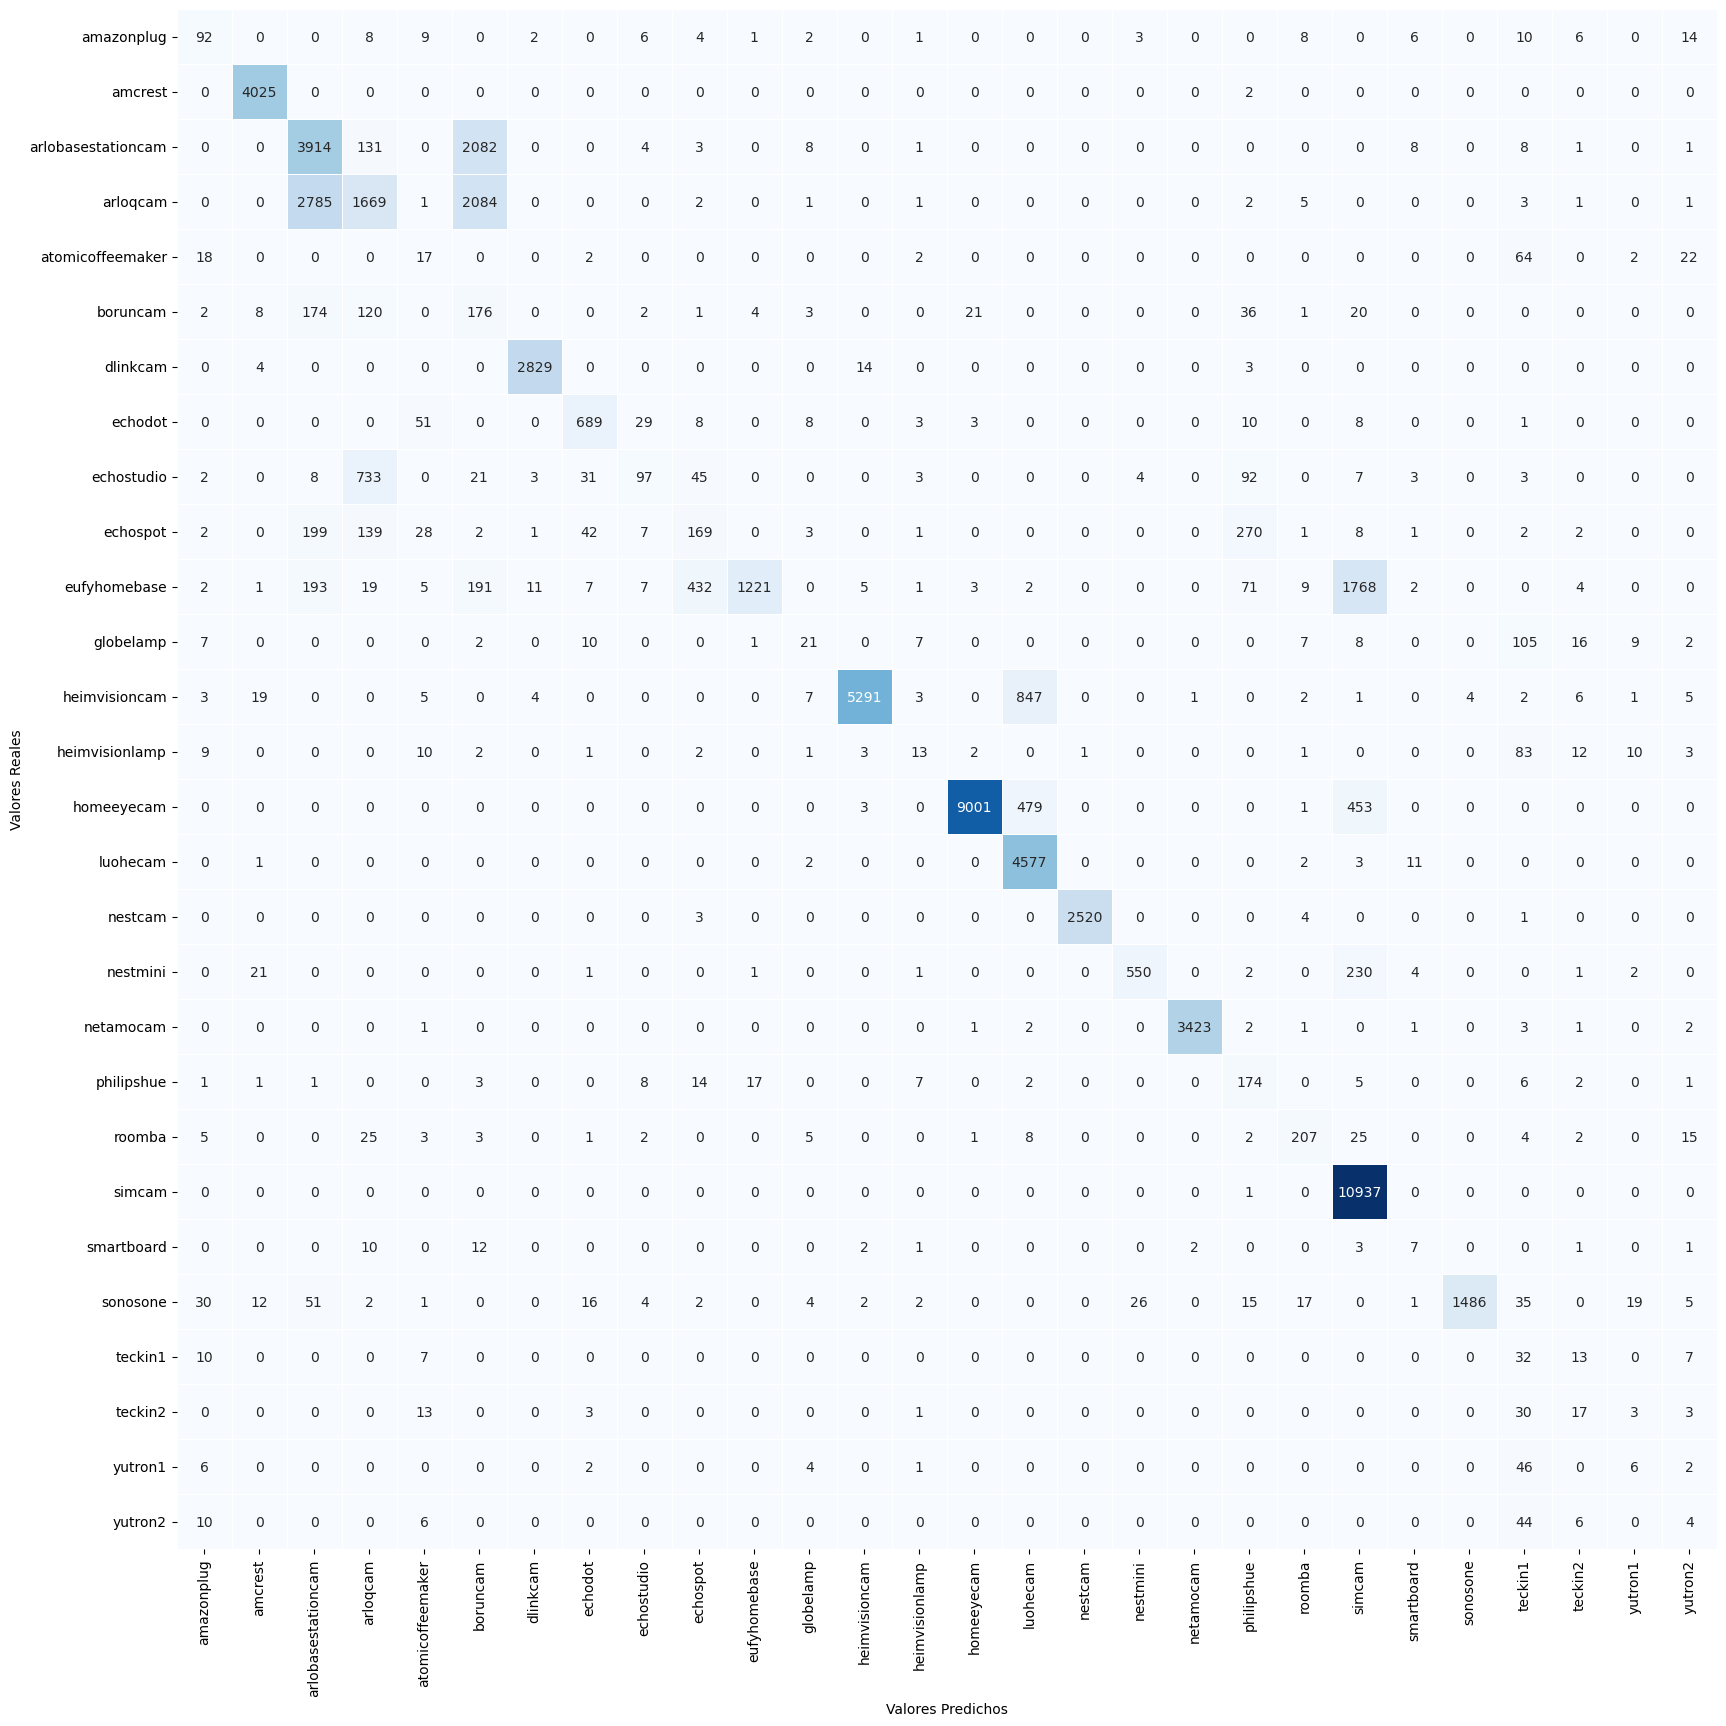

In [15]:
#Guardamos la predicción de MLP
y_pred_LGBM2 = LGBM2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_LGBM2)

class_names = ['amazonplug','amcrest','arlobasestationcam', 'arloqcam', 'atomicoffeemaker', 'boruncam',
               'dlinkcam', 'echodot', 'echostudio', 'echospot', 'eufyhomebase', 'globelamp', 'heimvisioncam', 
               'heimvisionlamp', 'homeeyecam', 'luohecam', 'nestcam', 'nestmini','netamocam', 'philipshue',
               'roomba', 'simcam', 'smartboard', 'sonosone', 'teckin1','teckin2','yutron1', 'yutron2']


sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [16]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(LGBM, metrics.classification_report(y_test, y_pred_LGBM2)))

Reporte del clasificador MLP: 
 LGBMClassifier()
                     precision    recall  f1-score   support

        amazonplug       0.46      0.53      0.50       172
           amcrest       0.98      1.00      0.99      4027
arlobasestationcam       0.53      0.64      0.58      6161
          arloqcam       0.58      0.25      0.35      6555
  atomicoffeemaker       0.11      0.13      0.12       127
          boruncam       0.04      0.31      0.07       568
          dlinkcam       0.99      0.99      0.99      2850
           echodot       0.86      0.85      0.85       810
          echospot       0.58      0.09      0.16      1052
        echostudio       0.25      0.19      0.22       877
      eufyhomebase       0.98      0.31      0.47      3954
         globelamp       0.30      0.11      0.16       195
     heimvisioncam       0.99      0.85      0.92      6201
    heimvisionlamp       0.27      0.08      0.13       153
        homeeyecam       1.00      0.91      0.95

## Introducimos los parámetros de forma manual:

In [158]:
LGBM3 = LGBMClassifier(num_leaves = 8,
                      n_estimators = 14, 
                      boosting_type = 'gbdt')
#10
#4 -> 0.829
start = time.time()
LGBM3.fit(x_train, y_train)
stop = time.time()

In [159]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM3.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM3.score(x_test, y_test): .3f}')

LGBM time: 1.5976498126983643s
Train accuracy :  0.961
Test accuracy :  0.835


## Matriz de confusión:

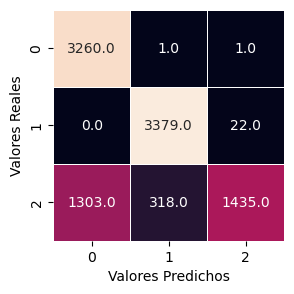

In [287]:
y_pred_LGBM3 = LGBM3.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_LGBM3)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [288]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(LGBM, metrics.classification_report(y_test, y_pred_LGBM2)))

Reporte del clasificador MLP: 
 LGBMClassifier()
                  precision    recall  f1-score   support

          AUDIO       0.64      1.00      0.78      3262
         CAMERA       0.98      1.00      0.99      3401
HOME AUTOMATION       0.99      0.38      0.55      3056

       accuracy                           0.80      9719
      macro avg       0.87      0.79      0.77      9719
   weighted avg       0.87      0.80      0.78      9719




# XGBoost:

In [ ]:
XGB = XGBClassifier()

In [ ]:
start = time.time()
XGB.fit(x_train, y_train)
stop = time.time()

In [ ]:
print(f"LGBM time: {stop - start}s")
print(f'Train accuracy : {LGBM.score(x_train, y_train): .3f}')
print(f'Test accuracy : {LGBM.score(x_test, y_test): .3f}')